# Chapter 14: Classifying Images with Deep Convolutional Neural Networks

In [1]:
import torch.nn as nn 
import torch
loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))
l2_lambda = 0.001
conv_layer = nn.Conv2d(in_channels=3,
                                        out_channels=5,
                                        kernel_size=5)
l2_penalty = l2_lambda * sum(
    [(p**2).sum() for p in conv_layer.parameters()]
)
loss_with_penalty = loss + l2_penalty
linear_layer = nn.Linear(10, 16)

In [2]:
####### Binary Cross-entropy
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)
target = torch.tensor([1.0])
bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()
print(f'BCE (w Probas): {bce_loss_fn(probas, target):.4f}')
print(f'BCE (w Logits): '
        f'{bce_logits_loss_fn(logits, target):.4f}')

BCE (w Probas): 0.3711
BCE (w Logits): 0.3711


In [3]:
####### Categorical Cross-entropy
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)
target = torch.tensor([2])
cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()
print(f'CCE (w Logits): '
        f'{cce_logits_loss_fn(logits, target):.4f}')
print(f'CCE (w Probas): '
        f'{cce_loss_fn(torch.log(probas), target):.4f}')

CCE (w Logits): 0.5996
CCE (w Probas): 0.5996


In [4]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)
mnist_dataset = torchvision.datasets.MNIST(
    root = image_path, train=True,
    transform=transform, download=True
)
from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(
    root = image_path, train=False,
    transform=transform, download=False
)

In [6]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

In [5]:
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding=2
    )
)
model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding=2
    )
)
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))

In [7]:
model.add_module('flatten', nn.Flatten())
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [9] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)
            is_correct = (
                torch.argmax(pred, dim=1) == y_batch
            ).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: '
                f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
                f'{accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [11]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9908 val_accuracy: 0.9861
Epoch 2 accuracy: 0.9877 val_accuracy: 0.9888
Epoch 3 accuracy: 0.9920 val_accuracy: 0.9894
Epoch 4 accuracy: 0.9930 val_accuracy: 0.9903
Epoch 5 accuracy: 0.9950 val_accuracy: 0.9924
Epoch 6 accuracy: 0.9952 val_accuracy: 0.9900
Epoch 7 accuracy: 0.9964 val_accuracy: 0.9911
Epoch 8 accuracy: 0.9962 val_accuracy: 0.9919
Epoch 9 accuracy: 0.9969 val_accuracy: 0.9914
Epoch 10 accuracy: 0.9976 val_accuracy: 0.9914
Epoch 11 accuracy: 0.9973 val_accuracy: 0.9901
Epoch 12 accuracy: 0.9982 val_accuracy: 0.9913
Epoch 13 accuracy: 0.9980 val_accuracy: 0.9917
Epoch 14 accuracy: 0.9971 val_accuracy: 0.9920
Epoch 15 accuracy: 0.9980 val_accuracy: 0.9913
Epoch 16 accuracy: 0.9985 val_accuracy: 0.9903
Epoch 17 accuracy: 0.9981 val_accuracy: 0.9927
Epoch 18 accuracy: 0.9982 val_accuracy: 0.9922
Epoch 19 accuracy: 0.9986 val_accuracy: 0.9914
Epoch 20 accuracy: 0.9984 val_accuracy: 0.9917


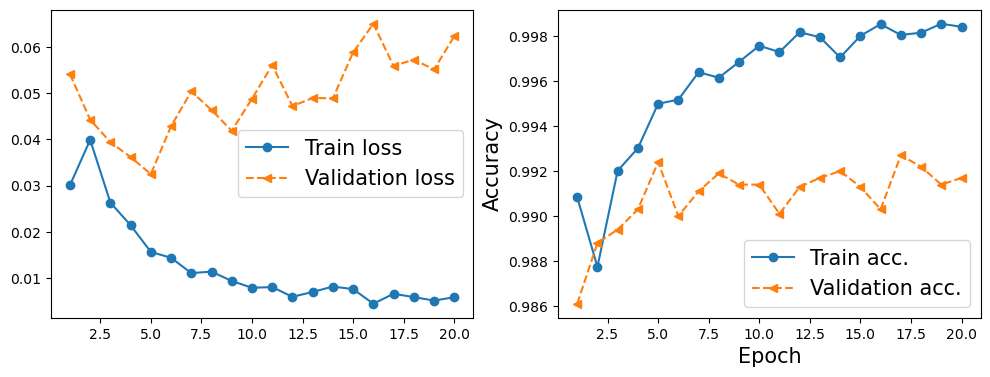

In [13]:
import matplotlib.pyplot as plt
import numpy as np
x_arr = np.arange(len(hist[0])) + 1
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [14]:
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (
    torch.argmax(pred, dim=1) == mnist_test_dataset.targets
).float()
print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9919


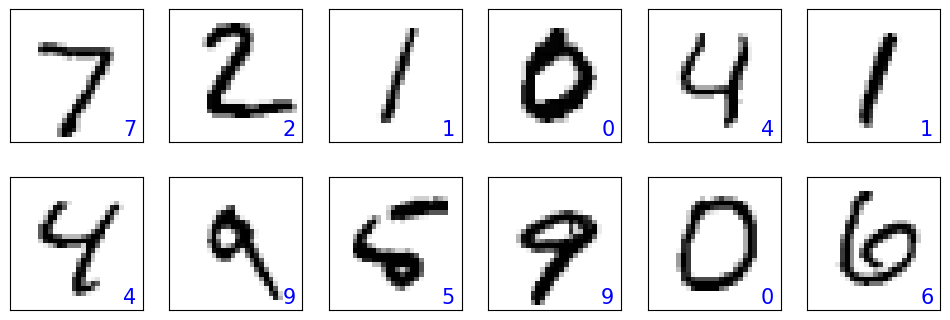

In [15]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(),
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)
plt.show()